Lets start by reading the data and making some column arrangements.

In [105]:
#imports and reading data
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns   


data = pd.read_csv("breast-cancer-wisconsin.data", encoding='latin1',index_col=0)

columns = [
    "Clump_thickness", "Uniformity_of_cell_size",
    "Uniformity_of_cell_shape", "Marginal_adhesion", "Single_epithelial_cell_size",
    "Bare_nuclei", "Bland_chromatin", "Normal_nucleoli", "Mitoses", "Class"
]
data.columns = columns

data = data.apply(pd.to_numeric, errors='coerce')

data['Class'] = data['Class'].replace({2: 0, 4: 1})

data.head()

,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses,Class
1000025,,,,,,,,,,
1002945,5,4,4,5,7,10.0,3,2,1,0
1015425,3,1,1,1,2,2.0,3,1,1,0
1016277,6,8,8,1,3,4.0,3,7,1,0
1017023,4,1,1,3,2,1.0,3,1,1,0
1017122,8,10,10,8,7,10.0,9,7,1,1


Lets see the general distribution of columns which may help us to understand the data. 


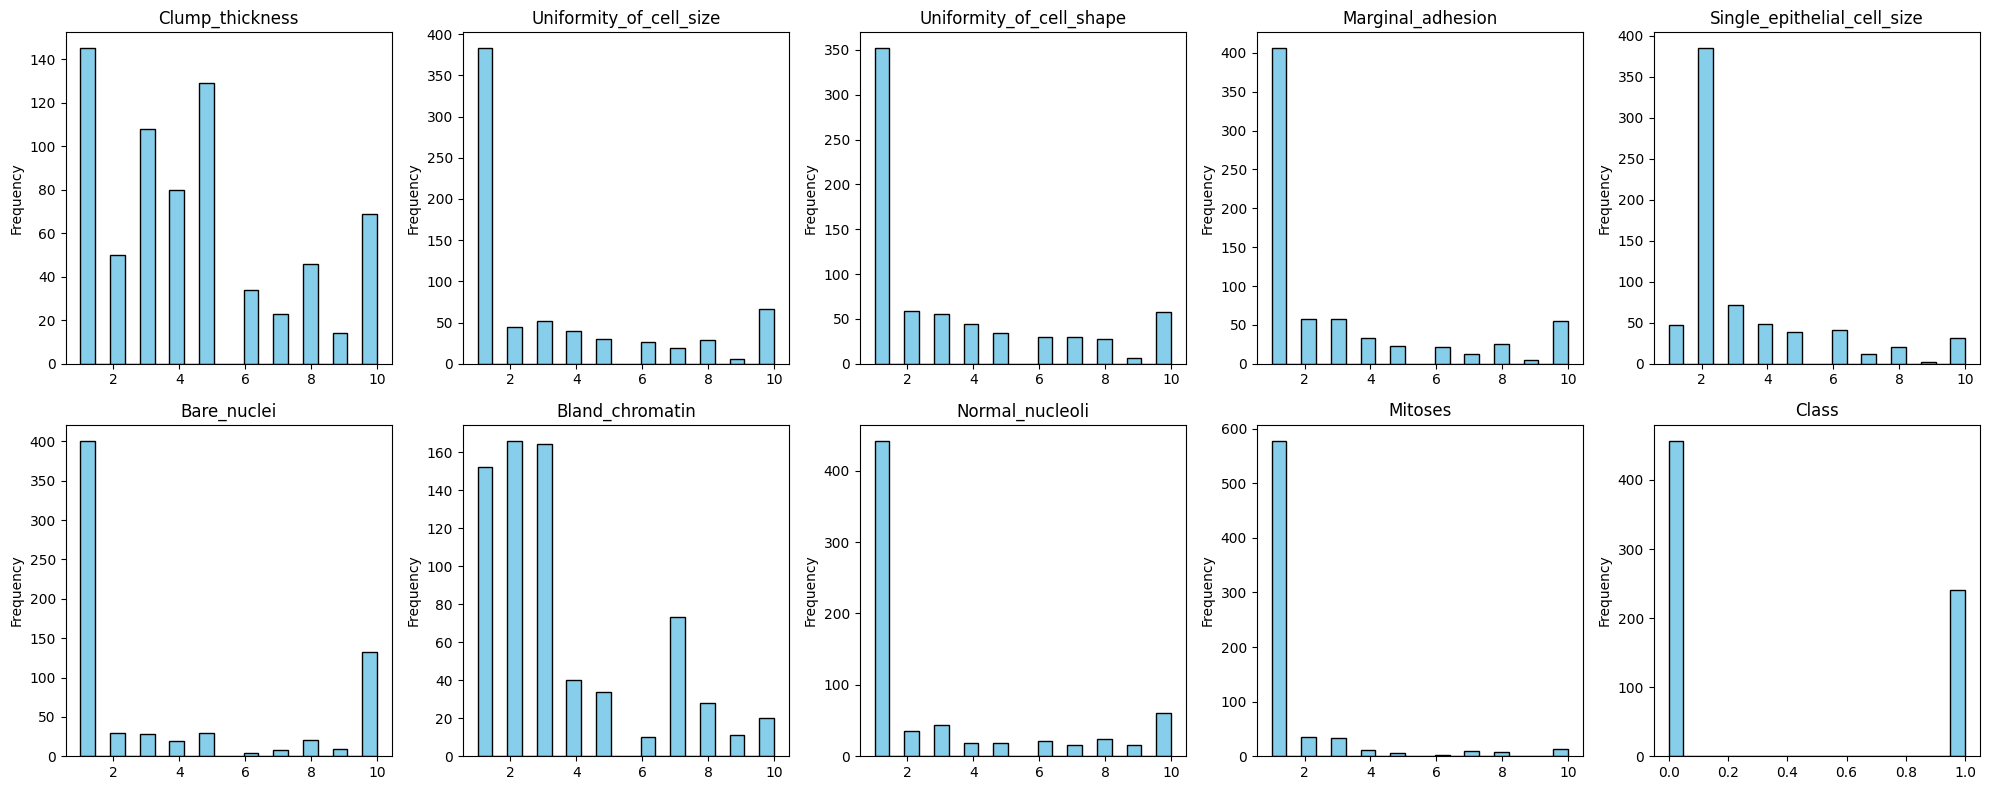

In [106]:
columns = [
     "Clump_thickness", "Uniformity_of_cell_size",
    "Uniformity_of_cell_shape", "Marginal_adhesion", "Single_epithelial_cell_size",
    "Bare_nuclei", "Bland_chromatin", "Normal_nucleoli", "Mitoses", "Class"
]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

axes = axes.flatten()

for i, column in enumerate(columns):
    ax = axes[i]
    ax.hist(data[column], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()

plt.show()

I check whether there is any null number or a redundant column which we must handle.

In [107]:
for col in data.columns:
    null_values_column = data[col].isnull().sum()
    print("Null values in column",col ,null_values_column)

for col in data.columns:
    unique_values_count = data[col].nunique()
    print("Unique values in column",col ,unique_values_count)
    if(unique_values_count > 20):
        data.drop(columns=col,inplace=True)

Null values in column Clump_thickness 0
Null values in column Uniformity_of_cell_size 0
Null values in column Uniformity_of_cell_shape 0
Null values in column Marginal_adhesion 0
Null values in column Single_epithelial_cell_size 0
Null values in column Bare_nuclei 16
Null values in column Bland_chromatin 0
Null values in column Normal_nucleoli 0
Null values in column Mitoses 0
Null values in column Class 0
Unique values in column Clump_thickness 10
Unique values in column Uniformity_of_cell_size 10
Unique values in column Uniformity_of_cell_shape 10
Unique values in column Marginal_adhesion 10
Unique values in column Single_epithelial_cell_size 10
Unique values in column Bare_nuclei 10
Unique values in column Bland_chromatin 10
Unique values in column Normal_nucleoli 10
Unique values in column Mitoses 9
Unique values in column Class 2


We can clearly see that the "Bare Nuclei" feature isn't balanced, so filling it with the mean value wouldn't be appropriate. However, we observe that the frequency of 1 is greater than the rest. Therefore, we can handle it using the mode.


In [108]:
data['Bare_nuclei'] = data['Bare_nuclei'].fillna(data['Bare_nuclei'].mode()[0])

for col in data.columns:
    null_values_column = data[col].isnull().sum()
    print("Null values in column",col ,null_values_column)

Null values in column Clump_thickness 0
Null values in column Uniformity_of_cell_size 0
Null values in column Uniformity_of_cell_shape 0
Null values in column Marginal_adhesion 0
Null values in column Single_epithelial_cell_size 0
Null values in column Bare_nuclei 0
Null values in column Bland_chromatin 0
Null values in column Normal_nucleoli 0
Null values in column Mitoses 0
Null values in column Class 0


Checking whether there are many outliers or not with boxplot method.

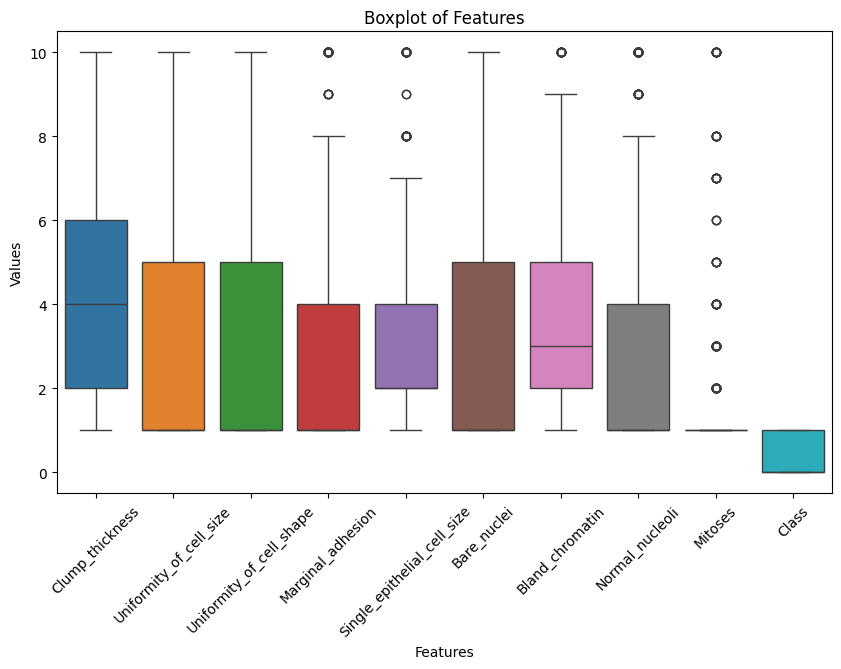

In [109]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[columns])
plt.title('Boxplot of Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

It is clear that there are many outliers with specific columns which removing may have negative effect in the future since our data set is really small. But we will try.

In [110]:
outliers = []
data_without_outliers = data.copy()
for col in data.columns:
    print(col)
    q25,q75 = np.percentile(a = data[col],q=[25,75])
    IQR = q75 - q25
    upperbound = q75 + IQR * 3
    lowerbound = q25 - IQR * 3

    outliers_filter = (data[col] < lowerbound) | (data[col] > upperbound)
    col_outliers = data[outliers_filter][col]
    outliers.extend(col_outliers.tolist())

    data_without_outliers = data_without_outliers[~outliers_filter]

print("Outliers:", len(outliers))


Clump_thickness
Uniformity_of_cell_size
Uniformity_of_cell_shape
Marginal_adhesion
Single_epithelial_cell_size
Bare_nuclei
Bland_chromatin
Normal_nucleoli
Mitoses
Class
Outliers: 120


C:\Users\Yusuf\AppData\Local\Temp\ipykernel_8684\788797715.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_without_outliers = data_without_outliers[~outliers_filter]


There are total of 120 outliers now lets see which of the classes has the most outliers.

In [111]:
print(data['Class'].value_counts())

print(data_without_outliers['Class'].value_counts())

Class
0    457
1    241
Name: count, dtype: int64
Class
0    444
1    134
Name: count, dtype: int64


We can clearly see that Class 1 lost most of the data it has. This probably will cause problems since there isn't enough data to provide good insight. But lets split our train and test data.

In [112]:
from sklearn.model_selection import train_test_split



X = data_without_outliers.drop('Class', axis=1)  
y = data_without_outliers['Class']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




And lets split our data without removing outliers.

In [113]:
X1 = data.drop('Class', axis=1)  
y1 = data['Class']  

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [121]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_score,recall_score

def runModel(model,X_train,X_test,y_train,y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test,y_pred)
    precision= precision_score(y_test, y_pred)
    recall = recall_score(y_test,y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", accuracy)
    print("Recall:", recall)
    print("Roc Auc:", precision)

    print(classification_report(y_test, y_pred))
    return model


Lets try it on my all time favorite model Random Forest.

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

bestModel = grid_search.best_estimator_

runModel(bestModel,X_train,X_test,y_train,y_test)
runModel(bestModel,X_train1,X_test1,y_train1,y_test1)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Accuracy: 0.9655172413793104
Roc Auc: 0.9540229885057471
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        87
           1       0.93      0.93      0.93        29

    accuracy                           0.97       116
   macro avg       0.95      0.95      0.95       116
weighted avg       0.97      0.97      0.97       116

Accuracy: 0.9785714285714285
Roc Auc: 0.9831460674157304
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        89
           1       0.94      1.00      0.97        51

    accuracy                           0.98       140
   macro avg       0.97      0.98      0.98       140
weighted avg       0.98      0.98      0.98       140



RandomForestClassifier(random_state=42)

We can clearly see that the Class 1 performed really weak even Class 0's performance is reduced. From now on I will use the data with outliers.


Logistic Regression


In [123]:
from sklearn.linear_model import LogisticRegression

logistic_regression_model = LogisticRegression(max_iter=1000)

runModel(logistic_regression_model,X_train1,X_test1,y_train1,y_test1)


Accuracy: 0.9714285714285714
Roc Auc: 0.973342145847103
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        89
           1       0.94      0.98      0.96        51

    accuracy                           0.97       140
   macro avg       0.97      0.97      0.97       140
weighted avg       0.97      0.97      0.97       140



LogisticRegression(max_iter=1000)

KNN

In [124]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)

runModel(knn_model,X_train1,X_test1,y_train1,y_test1)

Accuracy: 0.9857142857142858
Roc Auc: 0.9887640449438202
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        89
           1       0.96      1.00      0.98        51

    accuracy                           0.99       140
   macro avg       0.98      0.99      0.98       140
weighted avg       0.99      0.99      0.99       140



KNeighborsClassifier()

SVC

In [125]:
from sklearn.svm import SVC

svc_model = SVC()

runModel(svc_model,X_train1,X_test1,y_train1,y_test1)


Accuracy: 0.9785714285714285
Roc Auc: 0.9831460674157304
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        89
           1       0.94      1.00      0.97        51

    accuracy                           0.98       140
   macro avg       0.97      0.98      0.98       140
weighted avg       0.98      0.98      0.98       140



SVC()

XGBOOST

In [126]:
from xgboost import XGBClassifier


xgb_classifier = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, 
                               objective='binary:logistic', booster='gbtree', tree_method='auto', 
                               n_jobs=-1, random_state=42)

runModel(xgb_classifier,X_train1,X_test1,y_train1,y_test1)


Accuracy: 0.9714285714285714
Roc Auc: 0.973342145847103
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        89
           1       0.94      0.98      0.96        51

    accuracy                           0.97       140
   macro avg       0.97      0.97      0.97       140
weighted avg       0.97      0.97      0.97       140



XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

Neural Network

In [127]:
from sklearn.neural_network import MLPClassifier



mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', 
                               alpha=0.0001, batch_size='auto', learning_rate='constant', 
                               learning_rate_init=0.001, max_iter=200, shuffle=True, random_state=42)
runModel(mlp_classifier,X_train1,X_test1,y_train1,y_test1)

Accuracy: 0.9714285714285714
Roc Auc: 0.973342145847103
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        89
           1       0.94      0.98      0.96        51

    accuracy                           0.97       140
   macro avg       0.97      0.97      0.97       140
weighted avg       0.97      0.97      0.97       140



c:\Users\Yusuf\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)